# Predicting the Probability of an Airbnb Booking in NYC

## Buisness Understanding

Airbnb is an online marketplace for vacation rentals, cabins, houses, boats and more. Airbnb has round 150 million users and has listings all over the world. What is great about airbnb is that anyone can create there own listing anywhere from renting out a single bedroom to a home.

The purpose of this project is to create a model that is able to predict the probability of an Airbnb Host listing to be booked or not based on the features the listing has. This would be helpful for Airbnb Host who might want to know if the listing has a good chance of being booked based on what the listing has to offer.


In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import haversine as hs
import json
import os

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share";
from mpl_toolkits.basemap import Basemap
from folium.plugins import HeatMap
import plotly.graph_objs as go

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeClassifier, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
classification_report, accuracy_score, precision_score, plot_confusion_matrix

## Loading in the Data

I got this data from a website called InsideAirbnb. Its an open source data tool that has Airbnb listing information from all around the world.

In [301]:
df = pd.read_csv('/Users/raylinsoriano/Documents/Flatiron/capstone/data/listings (1).csv')

I also got this csv from kaggle, and this includes data of different attractions in Manhattan. I will use this data later to calculate the distance of the listings to each attractions.

In [302]:
# will be used later to create a map

attractions = pd.read_csv('/Users/raylinsoriano/Documents/Flatiron/capstone/data/cultural-institutions-by-block-and-lot.csv')


In [303]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20210901220703,2021-09-02,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,https://www.airbnb.com/rooms/3831,20210901220703,2021-09-02,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,...,4.81,4.72,4.65,NaN,f,1,1,0,0,5.03
2,5121,https://www.airbnb.com/rooms/5121,20210901220703,2021-09-02,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,4.91,4.47,4.52,NaN,f,1,0,1,0,0.54
3,5136,https://www.airbnb.com/rooms/5136,20210901220703,2021-09-02,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,...,5.00,4.50,5.00,NaN,f,1,1,0,0,0.02
4,5178,https://www.airbnb.com/rooms/5178,20210901220703,2021-09-02,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,4.40,4.86,4.36,NaN,f,1,0,1,0,3.64


In [304]:
df.shape

(36923, 74)

In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36923 entries, 0 to 36922
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36923 non-null  int64  
 1   listing_url                                   36923 non-null  object 
 2   scrape_id                                     36923 non-null  int64  
 3   last_scraped                                  36923 non-null  object 
 4   name                                          36910 non-null  object 
 5   description                                   35710 non-null  object 
 6   neighborhood_overview                         22510 non-null  object 
 7   picture_url                                   36923 non-null  object 
 8   host_id                                       36923 non-null  int64  
 9   host_url                                      36923 non-null 

In [306]:
pd.options.display.max_rows = 4000

#### Data Exploration

In [307]:
#Checking for duplicates 
df.duplicated().sum()

0

In [308]:
df['review_scores_rating'].describe()

count    27627.000000
mean         4.578315
std          0.854467
min          0.000000
25%          4.570000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

In [309]:
df['review_scores_accuracy'].describe()

count    26998.000000
mean         4.747624
std          0.493899
min          0.000000
25%          4.710000
50%          4.900000
75%          5.000000
max          5.000000
Name: review_scores_accuracy, dtype: float64

In [310]:
df['review_scores_location'].describe()

count    26987.000000
mean         4.753515
std          0.415131
min          0.000000
25%          4.670000
50%          4.880000
75%          5.000000
max          5.000000
Name: review_scores_location, dtype: float64

In [311]:
#this needs to be filled with the medium
df['host_listings_count'].describe()

count    36812.000000
mean        32.769423
std        213.664601
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       5069.000000
Name: host_listings_count, dtype: float64

In [312]:
#fill with median
df['beds'].describe()

count    36312.000000
mean         1.531422
std          1.123261
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         42.000000
Name: beds, dtype: float64

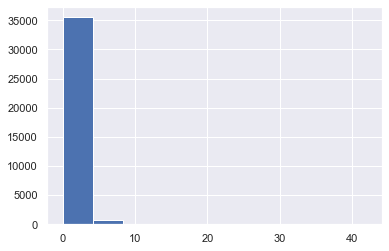

In [313]:
df['beds'].hist();

In [314]:
df['beds'].value_counts()

1.0     22421
2.0      7685
3.0      2728
0.0      1500
4.0      1196
5.0       382
6.0       202
7.0        81
8.0        50
9.0        29
10.0       12
12.0        8
11.0        6
13.0        4
16.0        2
15.0        2
42.0        1
21.0        1
24.0        1
17.0        1
Name: beds, dtype: int64

In [315]:
#fill with median
df['accommodates'].describe()

count    36923.000000
mean         2.797579
std          1.859867
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

In [316]:
#fill with median
df['bedrooms'].describe()

count    32987.000000
mean         1.327008
std          0.717335
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: bedrooms, dtype: float64

In [317]:
df['review_scores_value'].describe()

count    26987.000000
mean         4.651268
std          0.514201
min          0.000000
25%          4.560000
50%          4.790000
75%          5.000000
max          5.000000
Name: review_scores_value, dtype: float64

## Cleaning Data

After Looking at some of the features, now I will start filling in missing data with either the mean, median, or mode.

Also chaning strings objects for example, price to a numeric value.

In [318]:
df.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               13
description                                      1213
neighborhood_overview                           14413
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                         111
host_since                                        111
host_location                                     209
host_about                                      15287
host_response_time                              15743
host_response_rate                              15743
host_acceptance_rate                            15102
host_is_superhost                                 111
host_thumbnail_url          

In [319]:
#Changing the 
df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

0         19.0
1         86.0
2          NaN
3         33.0
4        100.0
         ...  
36918     96.0
36919     25.0
36920     78.0
36921     25.0
36922    100.0
Name: host_acceptance_rate, Length: 36923, dtype: float64

In [320]:
# Created a column for how many years the airbnb has been a host
df['host_since'] = pd.to_datetime(df['host_since'])
df['year'] = df['host_since'].apply(lambda date: date.year)

df['years_been_host'] = max(df['year']) - df['year']

In [321]:
#Created a column of how many verifications each host has
df['number_of_verifications'] = df.host_verifications.str.count(',')+1

In [322]:
#Created a column of how many amenities each host has
df['number_of_amenities'] = df.amenities.str.count(',')+1

In [323]:
#changing thid column so it can have the number of bathrooms
df['bathrooms_text'] = df.bathrooms_text.str.extract('(\d+)').astype(float)

In [324]:
#Chaning the price to be a float and removing the dollar sign
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [325]:
# Adding the median value to each missing value
median = df.filter(['host_listings_count','beds', 'bedrooms'
                    ,'accommodates','years_been_host','bathrooms_text']).median()

In [326]:
cols = ['host_listings_count','beds', 'bedrooms','accommodates','years_been_host','bathrooms_text']                          
df[cols]=df[cols].fillna(median)

In [327]:
# Adding the mean value to each missing value
mean = df.filter(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value']).mean()

In [328]:
cols2 = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location','review_scores_value']                          
df[cols2]=df[cols2].fillna(mean)

In [329]:
#Filling in the mode with the most frequent value
df = df.fillna(df.mode().iloc[0])

## Graphs

In [330]:
# set the filepath and load in a shapefile
fp = '/Users/raylinsoriano/Documents/Flatiron/capstone/data/Borough Boundaries.zip'
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.187194e+09,463868.937681,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,1.0,Manhattan,6.365759e+08,359804.890798,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,5.0,Staten Island,1.623636e+09,325929.794027,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
3,3.0,Brooklyn,1.934174e+09,728195.197649,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.040205e+09,900270.512975,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


<AxesSubplot:>

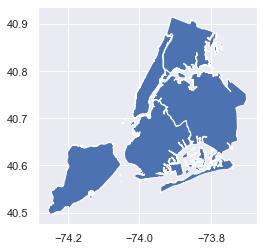

In [331]:
map_df.plot()

In [332]:
# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('neighbourhood_group_cleansed').size())
borough_df['mean_price'] = df.groupby('neighbourhood_group_cleansed').price.mean().values
# Joining the dataframes
borough_map_df = map_df.set_index('boro_name').join(borough_df)

borough_map_df.head()

,boro_code,shape_area,shape_leng,geometry,0,mean_price
boro_name,,,,,,
Bronx,2.0,1.187194e+09,463868.937681,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",1026,103.789474
Manhattan,1.0,6.365759e+08,359804.890798,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",16242,213.635451
Staten Island,5.0,1.623636e+09,325929.794027,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",313,119.370607
Brooklyn,3.0,1.934174e+09,728195.197649,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...",14392,143.821776
Queens,4.0,3.040205e+09,900270.512975,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...",4950,113.788687


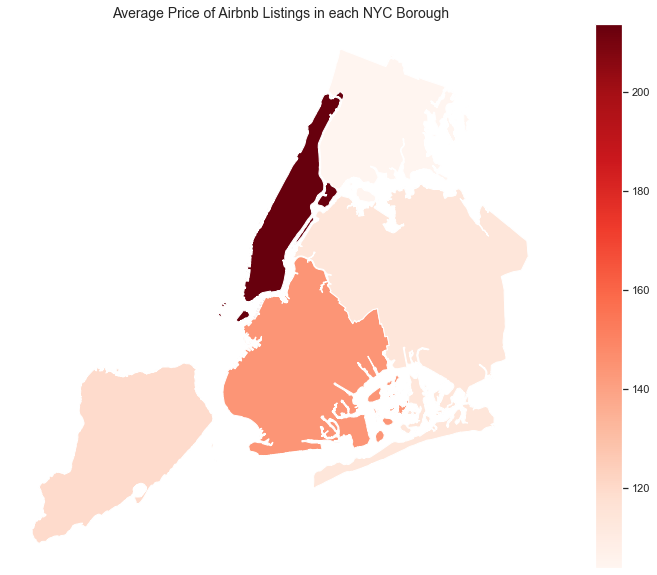

In [333]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 10))
borough_map_df.plot(column='mean_price', cmap='Reds', ax=ax2)

ax2.axis('off')
ax2.set_title('Average Price of Airbnb Listings in each NYC Borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.mean_price), vmax=max(borough_map_df.mean_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

The graph above shows the average price of each borough in NYC

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


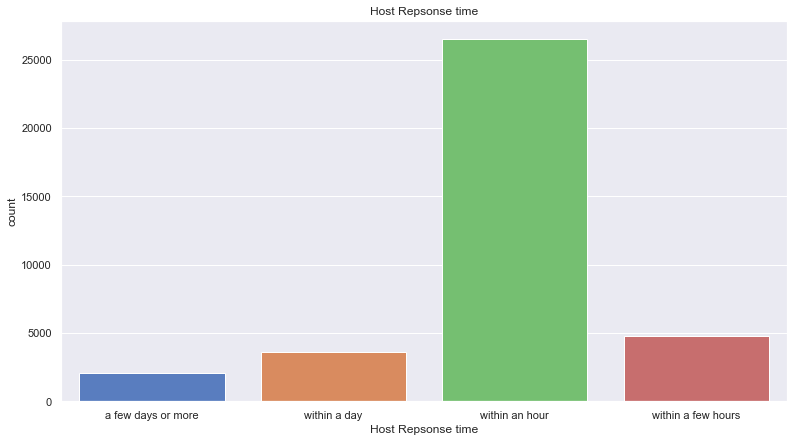

In [334]:
# graph showing the count of Host Response Time
plt.figure(figsize=(13,7))
plt.title("Host Repsonse time")
host_response_time_graph = sns.countplot(df.host_response_time, palette="muted")
host_response_time_graph.set_xlabel("Host Repsonse time")
fig = plt.gcf()
plt.show()

The graph above shows the counts of host response times. With in the hour having the highest count.

In [335]:
#Mapping the targets for graphing purposes
df['has_availability'] = df['has_availability'].map({'t': 'Have Availability',
                                     'f': 'No Availability'})

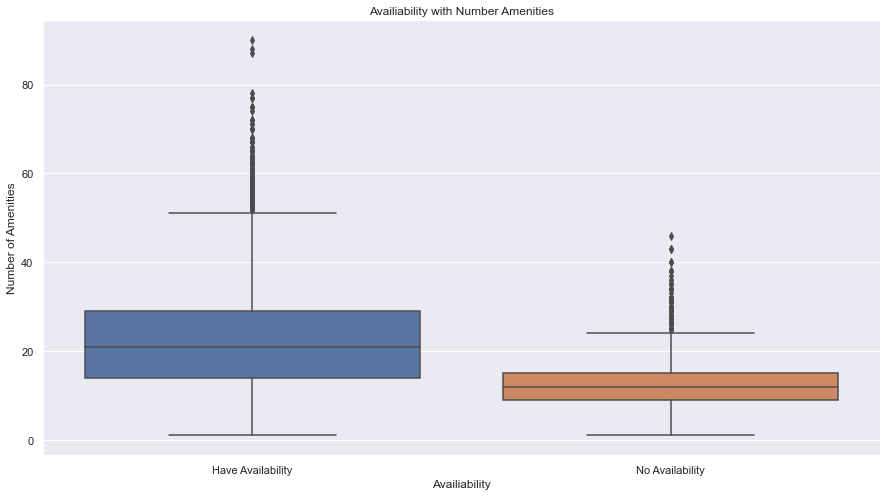

In [345]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="has_availability", y="number_of_amenities", data=df)
ax.set_xlabel('Availiability')
ax.set_ylabel('Number of Amenities')
ax.set_title('Availiability with Number Amenities');

Above is a boxplot of the number of amenities compared with listing with bookings that have or dont have availability. Looking at this graph it listings with no availablility generally had less amenities, which means for an airbnb host it might not matter having a huge number of amenities in there listing. 

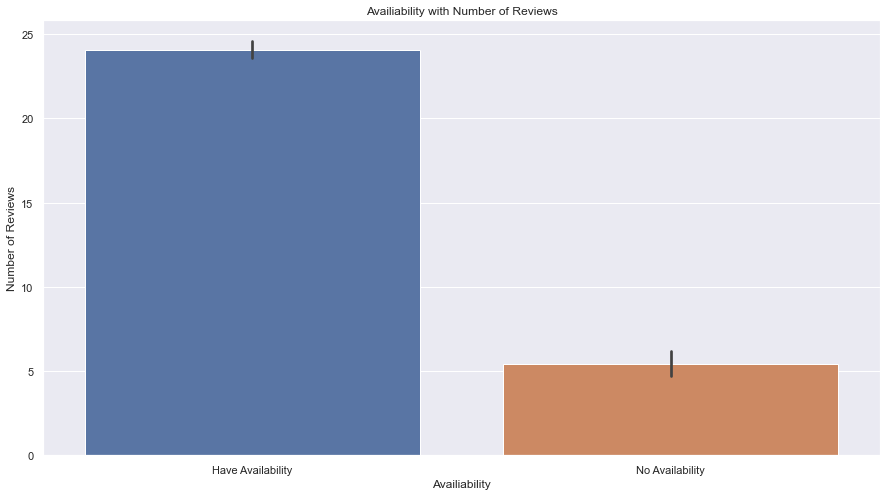

In [352]:
sns.set(rc = {'figure.figsize':(15,8)})
ax1 = sns.barplot(x="has_availability", y="number_of_reviews", data=df)
ax1.set_xlabel('Availiability')
ax1.set_ylabel('Number of Reviews')
ax1.set_title('Availiability with Number of Reviews');

Above the graph shows the number of reviews based on availiablity. You would think having more reviews would increase the chance of the listing to be booked but with this graph it is showing the opposite.

Now going to use the attraction dataset to create a map.

In [241]:
#Dropping any missing data
attractions = attractions.dropna()

In [242]:
attractions.isna().sum()

Organization Name                                               0
Preferred Address Line 1                                        0
Preferred Block-Lot Number                                      0
Constituency Code                                               0
Constituent Specific Attributes R-Secondary Type Description    0
Borough                                                         0
Postcode                                                        0
Latitude                                                        0
Longitude                                                       0
Community Board                                                 0
Council District                                                0
Census Tract                                                    0
BIN                                                             0
BBL                                                             0
NTA                                                             0
dtype: int

In [243]:
attractions.head()

,Organization Name,Preferred Address Line 1,Preferred Block-Lot Number,Constituency Code,Constituent Specific Attributes R-Secondary Type Description,Borough,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
3,Action Center To End World Hunger,6 River Terrace,16-270,Retail Space,A-Museums & Performing Arts,Manhattan,10282.0,40.715781,-74.016518,1.0,1.0,31703.0,1087518.0,1.000168e+09,Battery Park City-Lower Manhattan ...
4,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,Retail Space,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...
5,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,DLMA Former Member,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...
6,"3 Legged Dog, Inc.",80 Greenwich Street,18-100,Retail Space,A-Theaters & Cinemas,Manhattan,10006.0,40.707514,-74.013800,1.0,1.0,13.0,1078977.0,1.000180e+09,Battery Park City-Lower Manhattan ...
7,Church of Our Lady of the Rosary,7-8 State Street,7-Sep,Retail Space,C-Religious Institutions,Manhattan,10004.0,40.702398,-74.013287,1.0,1.0,9.0,1000019.0,1.000090e+09,Battery Park City-Lower Manhattan ...


In [244]:
#renaming column name
attractions.rename(columns={"Organization Name": "organization_name"}, inplace=True)

In [245]:
# concatenating latitude and longitude to create a consolidated location as accepted by havesine function
attractions['coor'] = list(zip(attractions.Latitude, attractions.Longitude))
df['coor'] = list(zip(df.latitude, df.longitude))

In [246]:
attractions.head()

,organization_name,Preferred Address Line 1,Preferred Block-Lot Number,Constituency Code,Constituent Specific Attributes R-Secondary Type Description,Borough,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,coor
3,Action Center To End World Hunger,6 River Terrace,16-270,Retail Space,A-Museums & Performing Arts,Manhattan,10282.0,40.715781,-74.016518,1.0,1.0,31703.0,1087518.0,1.000168e+09,Battery Park City-Lower Manhattan ...,"(40.715781, -74.016518)"
4,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,Retail Space,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,"(40.705717, -74.002453)"
5,Circle Line Downtown,"South Street Seaport, Pier 17",15-7501,DLMA Former Member,V-Sightseeing,Manhattan,10038.0,40.705717,-74.002453,1.0,1.0,1501.0,1000000.0,1.000730e+09,Battery Park City-Lower Manhattan ...,"(40.705717, -74.002453)"
6,"3 Legged Dog, Inc.",80 Greenwich Street,18-100,Retail Space,A-Theaters & Cinemas,Manhattan,10006.0,40.707514,-74.013800,1.0,1.0,13.0,1078977.0,1.000180e+09,Battery Park City-Lower Manhattan ...,"(40.707514, -74.0138)"
7,Church of Our Lady of the Rosary,7-8 State Street,7-Sep,Retail Space,C-Religious Institutions,Manhattan,10004.0,40.702398,-74.013287,1.0,1.0,9.0,1000019.0,1.000090e+09,Battery Park City-Lower Manhattan ...,"(40.702398, -74.013287)"


In [247]:
# formula that calculates the distance using longitude and latitude
def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

In [248]:
# loop that calculates the distance between each listing and attraction
for _,row in attractions.iterrows():
    df[row.organization_name]= df['coor'].apply(lambda x: distance_from(row.coor,x))

In [249]:
#pd.options.display.max_rows = 4000

In [250]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       ...
       'Tribute WTC', 'Center for Castle Garden Immigration',
       'Wall Street Synagogue', 'Manhattan By Sail', 'Poets House',
       'South Street Seaport Museum', 'Cannon's Walk',
       'The River Vineyard Christian Fellowship', 'Bike & Roll Bike Rentals',
       'NY Waterway Tours'],
      dtype='object', length=122)

In [251]:
#creating a map using folium
def create_map(df,attractions):
    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=12, tiles='OpenStreetMap')
    
   
    
    for _, row in df.iterrows():
         
        if row['Condition']=='Out':
            cluster_colour='blue'
        else:
            cluster_colour = 'green'
        
        folium.CircleMarker(
            location= [row['latitude'],row['longitude']],
            radius=5,
            popup= row[['Condition','id']],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
            ).add_to(m)
    
    for _, row in attractions.iterrows(): 
        folium.Marker(
            location= [row['Latitude'],row['Longitude']],
            radius=5,
            popup= row['organization_name'],
            color='red',
            fill=True,
            fill_color='red'
             ).add_to(m)
    for _, row in attractions.iterrows(): 
        folium.Circle(
            location= [row['Latitude'],row['Longitude']],
            radius=100,
            popup= row['organization_name'],
            color='black',
            fill=False,
        ).add_to(m)
        
    return m

In [252]:
# A list of some of the attraction
x_list = ['Tribute WTC', 'Center for Castle Garden Immigration',
       'Wall Street Synagogue', 'Manhattan By Sail', 'Poets House',
       'South Street Seaport Museum', 
       'The River Vineyard Christian Fellowship', 'Bike & Roll Bike Rentals',
       'NY Waterway Tours']

In [253]:
df['Condition']='Out'

for i in x_list:
    df['Condition'][df.Condition=='Out']=df[df.Condition=='Out'][i].apply(lambda x: 'In' if x<3 else 'Out')


/var/folders/10/1w2hpkhn2v9g5h3_0k0f70t40000gn/T/ipykernel_32021/3237076699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Condition'][df.Condition=='Out']=df[df.Condition=='Out'][i].apply(lambda x: 'In' if x<3 else 'Out')


In [ ]:
m= create_map(df,attractions)
m

Dropping columns not needed

In [254]:
df = df.drop(['host_url','listing_url', 'picture_url','host_thumbnail_url', 'host_picture_url','neighbourhood'
              ,'host_neighbourhood','property_type','bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights'
             ,'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm'
             ,'calendar_updated','calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d'
             ,'first_review','last_review', 'review_scores_value','license','reviews_per_month', 'neighborhood_overview'
             ,'host_response_rate', 'host_acceptance_rate','host_about', 'host_location', 'scrape_id','last_scraped'
             ,'host_since','year', 'neighbourhood_cleansed', 'amenities','host_name', 'name', 'host_id', 'description'
             , 'coor'
             
             ], axis=1)

Checking for missing values

In [255]:
df.isna().sum()


id                                                              0
host_response_time                                              0
host_is_superhost                                               0
host_listings_count                                             0
host_total_listings_count                                       0
host_verifications                                              0
host_has_profile_pic                                            0
host_identity_verified                                          0
neighbourhood_group_cleansed                                    0
latitude                                                        0
longitude                                                       0
room_type                                                       0
accommodates                                                    0
bathrooms_text                                                  0
bedrooms                                                        0
beds      

### Target

For my target I will be looking at the "has_availability" column. This data was last scraped on september 9, 2021, so I will be looking at listing availability until there. 

Text(0.5, 1.0, 'Target Class Frequency Count')

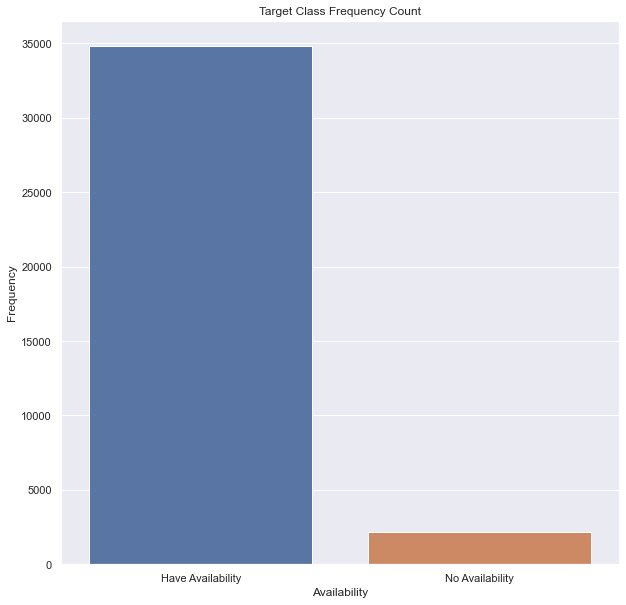

In [257]:
plt.figure(figsize = (10,10))
target_graph = sns.countplot(x=df['has_availability'])
target_graph.set_xlabel("Availability")
target_graph.set_ylabel("Frequency")
target_graph.set_title("Target Class Frequency Count")

Looking at the graph, this you can see that is highly unbalanced. 

In [258]:
df['has_availability'].value_counts()

Have Availability    34791
No Availability       2132
Name: has_availability, dtype: int64

In [259]:
df['has_availability'].value_counts(normalize=True)

Have Availability    0.942258
No Availability      0.057742
Name: has_availability, dtype: float64

Having the availability to book a listing explains around 94% while not having the availability to book explains for 5%.

In [260]:
#Mapping the targets to be numeric for the train-test-split
df['has_availability'] = df['has_availability'].map({'Have Availability': 0,
                                     'No Availability': 1,})

## Train/Test Split

Here we are going to split the data and test different models on the training data, while leaaving a portion to the side so we can test on our final model

In [56]:
X= df.drop(["has_availability",'id', 'latitude','longitude'],axis=1)
y= df["has_availability"]

X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y)

## One Hot Encode

Transforming the all the categorical data to dummies to run models

In [57]:
#Categorical variables to use
categorical_vars = ["host_response_time","host_has_profile_pic","host_identity_verified","host_is_superhost"
            ,"neighbourhood_group_cleansed","room_type","instant_bookable", "Condition"]

In [148]:
train = X_train[categorical_vars]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')
enc = ohe.fit(train)
train_dummies_trans = enc.transform(train)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categorical_vars)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names,index = X_train.index)

In [149]:
test = X_test[categorical_vars]
    
# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')

#Transforming the test data
test_dummies_trans = enc.transform(test)

# Dummies values in matrix form
test_data = test_dummies_trans.todense()


# Make them into Dataframe
test_dummies_trans_df = pd.DataFrame(test_data, columns=names,index = X_test.index)

Combining all the dummy variables with the numeric varibles

In [150]:
numerical = (X_train.select_dtypes(exclude='object'))
numerical = pd.DataFrame(numerical, index = X_train.index)
df_train = train_dummies_trans_df.merge(numerical, left_index = True , right_index=True)

In [151]:
numerical1 = (X_test.select_dtypes(exclude='object'))
numerical1 = pd.DataFrame(numerical1, index = X_test.index)
df_test = test_dummies_trans_df.merge(numerical1, left_index = True , right_index=True)

In [152]:
df_train.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,host_is_superhost_f,host_is_superhost_t,...,Tribute WTC,Center for Castle Garden Immigration,Wall Street Synagogue,Manhattan By Sail,Poets House,South Street Seaport Museum,Cannon's Walk,The River Vineyard Christian Fellowship,Bike & Roll Bike Rentals,NY Waterway Tours
3146,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,13.84,14.23,13.30,13.32,13.88,13.35,13.30,13.64,13.32,14.49
7306,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,5.50,5.08,5.25,4.71,6.25,4.84,4.86,5.79,4.71,5.21
29705,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,8.19,8.76,7.87,8.19,7.84,8.14,8.09,7.86,8.19,8.93
22771,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,13.55,13.82,12.97,12.84,13.78,12.90,12.87,13.43,12.84,14.10
9129,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,2.30,2.70,1.76,1.88,2.48,1.87,1.82,2.13,1.88,2.96


In [63]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and class target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision', 'recall', 'f1']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring, cv=5)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print('Cross_Val Accuracy', results['train_accuracy'].mean())
    print('##############')
    print('Training Precision:', results['train_precision'].mean())
    print('##############')
    print('Training  Recall:', results['train_recall'].mean())
    print('##############')
    print('Training  F1:', results['train_f1'].mean())

## Modeling 

For modeling I used Naive Bayes, Logistic Regression, XGBoost and Random Forest.

For my metrics I will be looking at accuracy to see accurate my models are preforming and precision to see how well my model is correctly predicting if the listing as availability or not.

## First Simple Model (baseline)

For my baseline model I used a Naive Bayes model.

In [64]:
fsm_pip = Pipeline([('nb', MultinomialNB())
                    ])

fsm_pip.fit(df_train, y_train)

Pipeline(steps=[('nb', MultinomialNB())])

In [65]:
print_cv_scores(fsm_pip, df_train, y_train)

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.94212973 0.94217487 0.94213235 0.65247811 0.94222262]
Training Accuracy 0.8842275372809322
##############
Cross_Val Accuracy 0.8842275372809322
##############
Training Precision: 0.23511071481646603
##############
Training  Recall: 0.20015624999999998
##############
Training  F1: 0.051037099095177896


My accuracy score preformed well with an 88%, however my precision preformed terribly with a score of 23%.

## Logisitic Regression Models

Now I will be trying Logistic Regression models to see how well they preform.

In [66]:
log_pipe = Pipeline([('lg', LogisticRegression(solver='liblinear',max_iter=100000000))
                    ])
log_pipe.fit(df_train,  y_train)

Pipeline(steps=[('lg',
                 LogisticRegression(max_iter=100000000, solver='liblinear'))])

In [67]:
print_cv_scores(log_pipe, df_train, y_train)

[0.94208459 0.94244572 0.94222262 0.94330595 0.94262887]
Training Accuracy 0.9425375510545448
##############
Cross_Val Accuracy 0.9425375510545448
##############
Training Precision: 0.619327731092437
##############
Training  Recall: 0.01532435007818608
##############
Training  F1: 0.028659761868946042


This model preformed much better than the baseline model by increasing the precision score 39% and increasing accuracy about 8%.

### Logisitc GridSearch

Now I will run a gridsearch using logistic regression parameters to see which parameters will give the best model scores.

In [68]:
grid = {'lg__class_weight': [None,'balanced'], 
         'lg__tol': [0.0001, 0.01, 0.1],
         'lg__C' : [0.0001,0.001,0.01],
         'lg__penalty': ['l1', 'l2']
        }

In [69]:
gridsearch = GridSearchCV(log_pipe, grid, return_train_score=True, scoring='precision',verbose=2)

gridsearch.fit(df_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.4s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.3s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.1s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.0s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.7s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.9s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.9s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.6s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.7s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.1s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.0001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END l

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   2.3s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.0s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.5s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   2.4s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   1.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.6s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.3s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.6s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.4s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.4s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.6s
[CV] END lg__C=0.001, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.001

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.1s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l1, lg__tol=0.1; total time=   0.1s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.7s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.0s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   1.8s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.0001; total time=   0.8s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.9s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.4s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.3s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.01; total time=   0.5s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.1s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.1s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=None, lg__penalty=l2, lg__tol=0.1; total time=   0.1s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   1.0s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.0001; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.01, lg__class_weight=balanced, lg__penalty=l1, lg__tol=0.01; total time=   0.2s
[CV] END lg__C=0.01, lg__class

GridSearchCV(estimator=Pipeline(steps=[('lg',
                                        LogisticRegression(max_iter=100000000,
                                                           solver='liblinear'))]),
             param_grid={'lg__C': [0.0001, 0.001, 0.01],
                         'lg__class_weight': [None, 'balanced'],
                         'lg__penalty': ['l1', 'l2'],
                         'lg__tol': [0.0001, 0.01, 0.1]},
             return_train_score=True, scoring='precision', verbose=2)

In [70]:
print('gridsearch best parameters: {}'.format(gridsearch.best_params_))
print('gridsearch best score: {}'.format(gridsearch.best_score_))

gridsearch best parameters: {'lg__C': 0.0001, 'lg__class_weight': None, 'lg__penalty': 'l2', 'lg__tol': 0.0001}
gridsearch best score: 0.5166666666666667


Now I will be using those parameters to see if if we get better model scores.

In [71]:
log_pipe2 = Pipeline([('lg', LogisticRegression(C=0.0001, solver='liblinear',max_iter=100000000))
                    ])
log_pipe2.fit(df_train,  y_train)

Pipeline(steps=[('lg',
                 LogisticRegression(C=0.0001, max_iter=100000000,
                                    solver='liblinear'))])

In [72]:
print_cv_scores(log_pipe2, df_train, y_train)


[0.94235544 0.94235544 0.94222262 0.94244832 0.94262887]
Training Accuracy 0.9424021369583315
##############
Cross_Val Accuracy 0.9424021369583315
##############
Training Precision: 0.6279761904761905
##############
Training  Recall: 0.0054727814698983576
##############
Training  F1: 0.010838614878396024


The precision score only increased my 1%.

#### Logistic with Standard Scaler

In [73]:
log_pipe_scale = Pipeline([('ss', StandardScaler() ),
                           ('lg', LogisticRegression(solver='liblinear',max_iter=100000000))
                    ])
log_pipe_scale.fit(df_train,  y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lg',
                 LogisticRegression(max_iter=100000000, solver='liblinear'))])

In [74]:
print_cv_scores(log_pipe_scale, df_train, y_train)

[0.94289712 0.94316797 0.94353164 0.94366706 0.94317053]
Training Accuracy 0.9432868652621897
##############
Cross_Val Accuracy 0.9432868652621897
##############
Training Precision: 0.5962472452841927
##############
Training  Recall: 0.055188990422204855
##############
Training  F1: 0.10083244130090066


Using standard scaling the logistic model preformed worse with precision score going down to 59%

#### Logistic with SMOTE 

Now I will try SMOTE to help with unbalanced target.

In [77]:
log_smote_pipe = imbpipe([('smote', SMOTE()),
                        ('lg', LogisticRegression(C=0.0001,solver='liblinear',max_iter=100000000))
                    ])

log_smote_pipe.fit(df_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('lg',
                 LogisticRegression(C=0.0001, max_iter=100000000,
                                    solver='liblinear'))])

In [78]:
print_cv_scores(log_smote_pipe, df_train, y_train)

[0.67665779 0.64081614 0.64633926 0.76812314 0.64877674]
Training Accuracy 0.6761426150937193
##############
Cross_Val Accuracy 0.6761426150937193
##############
Training Precision: 0.15133363016496015
##############
Training  Recall: 0.97576304730258
##############
Training  F1: 0.2612581548216719


Using SMOTE the model preformed horribly with precision score at 15%.

#### Logistic with SMOTE and Standard Scaler

In [79]:
log_smote_pipe_sc2 = imbpipe([('ss', StandardScaler()),
                        ('smote', SMOTE()),
                        ('lg', LogisticRegression(solver='liblinear',max_iter=100000000))
                    ])

log_smote_pipe_sc2.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('lg',
                 LogisticRegression(max_iter=100000000, solver='liblinear'))])

In [80]:
print_cv_scores(log_smote_pipe_sc2, df_train, y_train)

[0.80779127 0.80873922 0.81493184 0.81168186 0.80743884]
Training Accuracy 0.8101166067571768
##############
Cross_Val Accuracy 0.8101166067571768
##############
Training Precision: 0.22635093463737865
##############
Training  Recall: 0.9462160379202501
##############
Training  F1: 0.36530514381332874


Using SMOTE and standard scaler the model didnt improve as much with precision score at 21% and accuracy score falling down to 82%.

## XGBoost Models

Now I will be trying XGBoost to see how well my model preform on training data.

In [81]:
xgb_pipe = Pipeline([('xgb', XGBClassifier(objective='binary:logistic',use_label_encoder=False, eval_metric='logloss'))
                    ])
xgb_pipe.fit(df_train,y_train)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [82]:
print_cv_scores(xgb_pipe, df_train, y_train)

[0.98194375 0.98113122 0.980455   0.97923626 0.97959736]
Training Accuracy 0.9804727189218972
##############
Cross_Val Accuracy 0.9804727189218972
##############
Training Precision: 0.9650090771421829
##############
Training  Recall: 0.6866795347928069
##############
Training  F1: 0.802325828487759


This model looks like it preforms very well but that could be due to overfiting, so I will be running a gridsearch to see which parameters will give the best score for the XGBoost model.

#### XGBoost GridSearch

In [83]:
grid3 = {"xgb__max_depth": [10, 15, 20],
        "xgb__min_child_weight": [10, 25, 50], 
        "xgb__colsample_bytree" : [1, 2, 3, 4]
       
       
       }

gridsearch3 = GridSearchCV(xgb_pipe, grid3, return_train_score=True, scoring='precision',verbose=2)

In [84]:
gridsearch3.fit(df_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  12.3s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  11.5s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  14.1s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  11.3s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=10; total time=  11.1s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  11.0s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  10.4s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  10.2s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb__min_child_weight=25; total time=  10.2s
[CV] END xgb__colsample_bytree=1, xgb__max_depth=10, xgb

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=2, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=3, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=10, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=15, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=10; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=25; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.1s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst =

[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s
[CV] END xgb__colsample_bytree=4, xgb__max_depth=20, xgb__min_child_weight=50; total time=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      eval_metric='logloss',
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                                      max_depth=6,
                                                      min

In [86]:
print('gridsearch best parameters: {}'.format(gridsearch3.best_params_))
print('gridsearch best score: {}'.format(gridsearch3.best_score_))

gridsearch best parameters: {'xgb__colsample_bytree': 1, 'xgb__max_depth': 10, 'xgb__min_child_weight': 50}
gridsearch best score: 0.4896099266152742


In [87]:
xgb_pipe2 = Pipeline([('xgb', XGBClassifier(colsample_bytree= 1, max_depth= 10, min_child_weight= 50, 
                                            eval_metric='logloss', use_label_encoder=False))
                    ])


xgb_pipe2.fit(df_train, y_train)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=50, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [88]:
print_cv_scores(xgb_pipe2, df_train, y_train)


[0.95869634 0.95810951 0.95919473 0.95955584 0.95878848]
Training Accuracy 0.9588689790182379
##############
Cross_Val Accuracy 0.9588689790182379
##############
Training Precision: 0.826195092889465
##############
Training  Recall: 0.3644461004691165
##############
Training  F1: 0.5056639206183315


Using the parameters from the gridsearch, the model preformed very well with an accuracy score of 95% and a precision score of 83%. This is an 20% increase from my best logisitc regression model. 

#### XGBoost with Standard Scaler

In [159]:
xgb_pipe_ss = Pipeline([('ss', StandardScaler()),
                        ('xgb', XGBClassifier(objective='binary:logistic',use_label_encoder=False, 
                                              eval_metric='logloss', colsample_bytree= 1, max_depth= 10, 
                                              min_child_weight= 50,))
                    ])
xgb_pipe_ss.fit(df_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=50, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [160]:
print_cv_scores(xgb_pipe_ss, df_train, y_train)

[0.95869634 0.95810951 0.95919473 0.95955584 0.95878848]
Training Accuracy 0.9588689790182379
##############
Cross_Val Accuracy 0.9588689790182379
##############
Training Precision: 0.826195092889465
##############
Training  Recall: 0.3644461004691165
##############
Training  F1: 0.5056639206183315


Using standard scaler did not change the scores for the model.

#### XGBoost with SMOTE

In [91]:
xgb_sm_pipe = imbpipe([('smote', SMOTE()),
                        ('xgb', XGBClassifier(colsample_bytree= 1, max_depth= 10, min_child_weight= 25, 
                                            eval_metric='logloss', use_label_encoder=False))
                    ])

xgb_sm_pipe.fit(df_train,y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [92]:
print_cv_scores(xgb_sm_pipe,df_train,y_train)


[0.97512752 0.97431499 0.97404532 0.97395504 0.97381963]
Training Accuracy 0.9742525001581063
##############
Cross_Val Accuracy 0.9742525001581063
##############
Training Precision: 0.857122735805444
##############
Training  Recall: 0.6651048182173573
##############
Training  F1: 0.7489260449913646


Using SMOTE increased the model preformance for accuracy to a 97% and a precision score of 86%.

#### XGBoost with SMOTE and Standard Scaler

In [93]:
xgb_sm_pipe_sc = imbpipe([('ss', StandardScaler()),
                        ('smote', SMOTE()),
                        ('xgb', XGBClassifier(colsample_bytree= 1, max_depth= 10, min_child_weight= 25, 
                                            eval_metric='logloss', use_label_encoder=False))
                    ])

xgb_sm_pipe_sc.fit(df_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosi

In [94]:
print_cv_scores(xgb_sm_pipe_sc,df_train,y_train)


[0.97571435 0.97512752 0.97774668 0.97558003 0.97517378]
Training Accuracy 0.9758684737913914
##############
Cross_Val Accuracy 0.9758684737913914
##############
Training Precision: 0.8744171492110345
##############
Training  Recall: 0.6797967161845191
##############
Training  F1: 0.7648467360607344


Using SMOTE and standard scaling the model scores increased even more with accuracy at 97% and precision at 87%.

## Random Forest Models

Now I will be running Random Forest models and see how well the preform.

In [95]:
rf_pipe = Pipeline([('rf', RandomForestClassifier())
                    ])
rf_pipe.fit(df_train, y_train)

Pipeline(steps=[('rf', RandomForestClassifier())])

In [96]:
print_cv_scores(rf_pipe, df_train, y_train)


[0.99995486 0.99995486 1.         1.         1.        ]
Training Accuracy 0.9999819437547963
##############
Cross_Val Accuracy 0.9999819437547963
##############
Training Precision: 1.0
##############
Training  Recall: 0.9996872556684909
##############
Training  F1: 0.9998435666797029


This model seems like it is scoring perfectly but that is mostly due to overfitting. I will run a gridsearch to see what the best parameters to help with overfitting.

#### Random Forest Gridsearch

In [97]:
grid2 = {"rf__class_weight": [None, 'balanced'],
        "rf__n_estimators": [10,25 , 50], 
        "rf__max_depth" : [10, 15, 20], 
        "rf__min_samples_leaf" : [1, 2, 3]
       
       
       }

gridsearch2 = GridSearchCV(rf_pipe, grid2, return_train_score=True, scoring='precision',verbose=2)

In [98]:
gridsearch2.fit(df_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.4s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.4s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.4s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.4s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=

/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   0.9s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   1.8s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   2.1s


/Users/raylinsoriano/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50; total time=   1.9s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.7s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.9s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=10; total time=   0.6s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=None, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimato

[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   2.4s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   2.2s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   3.0s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=50; total time=   2.7s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimato

[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.2s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.2s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=25; total time=   1.1s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.3s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.4s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.3s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   2.9s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf__min_samples_leaf=1, rf__n_estimators=50; total time=   3.2s
[CV] END rf__class_weight=balanced, rf__max_depth=15, rf

[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=10; total time=   0.5s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.3s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.3s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.2s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.3s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_leaf=3, rf__n_estimators=25; total time=   1.3s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf

GridSearchCV(estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__class_weight': [None, 'balanced'],
                         'rf__max_depth': [10, 15, 20],
                         'rf__min_samples_leaf': [1, 2, 3],
                         'rf__n_estimators': [10, 25, 50]},
             return_train_score=True, scoring='precision', verbose=2)

In [99]:
print('gridsearch best parameters: {}'.format(gridsearch2.best_params_))
print('gridsearch best score: {}'.format(gridsearch2.best_score_))

gridsearch best parameters: {'rf__class_weight': None, 'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 10}
gridsearch best score: 0.7928571428571429


In [103]:
rf_pipe2 = Pipeline([('rf', RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=3))
                    ])
rf_pipe2.fit(df_train,y_train)


Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        n_estimators=10))])

In [104]:
print_cv_scores(rf_pipe2, df_train, y_train)


[0.94465761 0.94370966 0.94479552 0.944299   0.94326081]
Training Accuracy 0.9441445189786405
##############
Cross_Val Accuracy 0.9441445189786405
##############
Training Precision: 0.8942518128102221
##############
Training  Recall: 0.03736476250977326
##############
Training  F1: 0.07140126980572656


#### Random Forest with Standard Scaler

In [194]:
rf_pipe_scaled = Pipeline([('ss', StandardScaler()),
                    ('rf', RandomForestClassifier(min_samples_leaf=3))
                    ])
rf_pipe_scaled.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestClassifier(min_samples_leaf=3))])

In [195]:
print_cv_scores(rf_pipe_scaled, df_train, y_train)


[0.97900961 0.9776554  0.98090638 0.98027444 0.98004875]
Training Accuracy 0.9795789172610952
##############
Cross_Val Accuracy 0.9795789172610952
##############
Training Precision: 0.999492385786802
##############
Training  Recall: 0.6466505815089914
##############
Training  F1: 0.7850985490051003


Using standard scaler is looks like the model is preforming extremely well but that it due to most likey to overfitting.

#### Random Forest with SMOTE

In [192]:
rf_pipe_sm = imbpipe([('smote', SMOTE()),
                    ('rf', RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=3))
                    ])

rf_pipe_sm.fit(df_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('rf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        n_estimators=10))])

In [193]:
print_cv_scores(rf_pipe_sm, df_train, y_train)


[0.88579425 0.88516228 0.87790015 0.88322651 0.87875779]
Training Accuracy 0.8821681949673159
##############
Cross_Val Accuracy 0.8821681949673159
##############
Training Precision: 0.3088453854363222
##############
Training  Recall: 0.8397402756059421
##############
Training  F1: 0.4515072370919267


Using SMOTE the model preformed worse with a precision score of 31% and accuracy score of 88%

#### Random Forest with SMOTE and Standard Scaler

In [113]:
rf_pipe_sm_sc = imbpipe([('ss', StandardScaler()),
                    ('smote', SMOTE()),
                    ('rf', RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=3))
                    ])

rf_pipe_sm_sc.fit(df_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('smote', SMOTE()),
                ('rf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        n_estimators=10))])

In [114]:
print_cv_scores(rf_pipe_sm_sc,df_train, y_train )


[0.86624836 0.87261319 0.86973007 0.86927869 0.86611899]
Training Accuracy 0.8687978591816714
##############
Cross_Val Accuracy 0.8687978591816714
##############
Training Precision: 0.29330491538132264
##############
Training  Recall: 0.9022838887802971
##############
Training  F1: 0.44267995977696517


Using SMOTE and standard scaling did even worse with an precision score of 29% and accuracy slightly improved since the SMOTE model with a score of 86%.

## Final Model

For my final model I will be using Random Forest. I will be using the model pipline that had the best parameters from the gridsearch and had a precision score of 89% and accuracy score of 94%. So now I will be using for unseen data.

In [362]:
rf_pipe2.score(df_test, y_test)

0.9430180912143863

In [363]:
y_pred = rf_pipe2.predict(df_test)


In [364]:
precision_score(y_test, y_pred)


0.7692307692307693

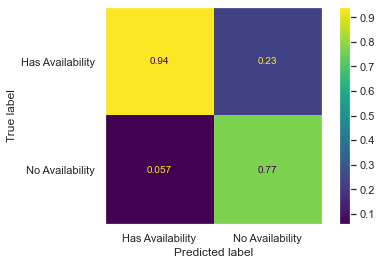

In [396]:
display_labels= ['Has Availability', 'No Availability']
plot_confusion_matrix(rf_pipe2, df_test, y_test, normalize = 'pred', display_labels=display_labels)
plt.grid(None)


Looking at the confusion matrix this model struggled at predicting listings that didn't have availablity when it actually did.

In [196]:
pd.DataFrame(rf_pipe2.predict_proba(df_test)*100, columns=rf_pipe2.classes_)

,0,1
0,71.738259,28.261741
1,100.000000,0.000000
2,79.580056,20.419944
3,88.582539,11.417461
4,99.495650,0.504350
...,...,...
9226,82.605958,17.394042
9227,98.858093,1.141907
9228,100.000000,0.000000
9229,100.000000,0.000000


Here is a dataframe that has the probabilities of wither a listing will be booked or not. Zero meaning it will be avaible to be booked and One meaning the probablility of not having avaliablity to be booked. 

In [398]:
# Lookimg at feature importance
rf_pipe2[0].feature_importances_

array([1.30764859e-04, 9.44524910e-06, 5.02872286e-04, 2.56832190e-02,
       1.19241171e-03, 2.89269179e-04, 1.16293521e-02, 5.23715501e-03,
       2.01724933e-03, 1.87371212e-03, 0.00000000e+00, 3.64846454e-04,
       6.23775735e-04, 3.62466834e-04, 1.73445282e-04, 9.37406981e-03,
       0.00000000e+00, 1.25713118e-02, 7.10776553e-04, 6.42146000e-02,
       5.32512988e-02, 0.00000000e+00, 2.14572636e-05, 2.72374481e-02,
       1.65087783e-02, 2.09527416e-02, 7.89478466e-04, 1.21825029e-03,
       2.13225520e-04, 1.06505283e-02, 3.72061497e-02, 1.34069742e-02,
       4.92665545e-02, 4.37835131e-02, 5.68243596e-02, 8.22618260e-02,
       3.56871166e-02, 3.18151452e-02, 1.26158451e-02, 9.38741903e-03,
       7.42453161e-03, 1.43668776e-02, 6.46171403e-03, 8.86436759e-03,
       1.53085220e-02, 1.93024809e-02, 1.61878342e-03, 1.41031691e-02,
       5.72057164e-03, 5.85273979e-02, 4.49773710e-03, 4.96215961e-03,
       5.14792856e-03, 5.71929427e-03, 2.41690029e-03, 3.98061232e-03,
      

In [399]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_train.columns, rf_pipe2[0].feature_importances_):
    feats[feature] = importance #add the name/value pair

In [397]:
feats

{'host_response_time_a few days or more': 0.00013076485939479205,
 'host_response_time_within a day': 9.445249098055673e-06,
 'host_response_time_within a few hours': 0.0005028722863576098,
 'host_response_time_within an hour': 0.02568321895461324,
 'host_has_profile_pic_f': 0.001192411713387027,
 'host_has_profile_pic_t': 0.00028926917915325824,
 'host_identity_verified_f': 0.011629352107071826,
 'host_identity_verified_t': 0.005237155012865067,
 'host_is_superhost_f': 0.0020172493251871754,
 'host_is_superhost_t': 0.0018737121179117414,
 'neighbourhood_group_cleansed_Bronx': 0.0,
 'neighbourhood_group_cleansed_Brooklyn': 0.00036484645445376325,
 'neighbourhood_group_cleansed_Manhattan': 0.0006237757351283423,
 'neighbourhood_group_cleansed_Queens': 0.0003624668335808277,
 'neighbourhood_group_cleansed_Staten Island': 0.00017344528200617925,
 'room_type_Entire home/apt': 0.009374069812721939,
 'room_type_Hotel room': 0.0,
 'room_type_Private room': 0.012571311806117494,
 'room_type_Sh

# Conclusion

In conclusion, my best model for predicting the probabilty of whether a listing would be booked or not was Random Forest. This model is could also be useful for other airbnb listings in other cities. This model could also be useful for airbnb host to help figure out what features could help improve there listing to be booked.

# Future Steps

1. Include data from other cities and comapre it to NYC

2. Look for more data with more features. For example, the date of when a listing was booked to see how maybe holidays could effecting booking